# Ensemble methods


During this classes we implement few ensemble methods:
* boosting,
* bagging.

There are more explained in the lectures. 

## AdaBoost

AdaBoost consists of following steps:
* initialize weights to $\frac{1}{N}$, where $N$ is the number of datapoints,
* loop until 
  $\varepsilon_{t}<\frac{1}{2}$
  or maximum number of iteration is reached,

* train classifier on ${S,w^{(t)}}$ and get a hypothesis $h_{t}(x_{n})$ for datapoints $x_{n}$,

* compute error $\varepsilon_{t}=\sum_{n=1}^{N}w_{n}^{(t)}I(y_{n}\neq h_{t}(x_{n}))$,       

* set $\alpha_{t}=\log(\frac{1-\varepsilon_{t}}{\varepsilon_{t}})$.
  
* update weights $w_{n}^{(t+1)}=\frac{w_{n}^{(t)}\exp{\alpha_{t}I(y_{n}\neq h_{t}(x_{n}))}}{Z_{t}}$,
  where $Z_{t}$ is a normalization constant,

* output $f(X)=\text{sign}(\sum_{t=1}^{T}\alpha_{t}h_{t}(x))$.
  
Example taken from Marsland, Machine Learning: https://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html.


First, we need to import libraries:

In [4]:
import pylab as pl
import numpy as np

%matplotlib inline

The training part consis

In [5]:
def train(data,classes,weights,whichdim):
    error = np.zeros(10)
    for value in range(0,10,1):
        val = float(value)/10
        classn = np.where(data[whichdim,:]<val,-1,1)
        ind = np.where(classes!=classn)
        error[value] = np.sum(weights[ind])

    return whichdim,float(np.argmin(error))/10,1-whichdim  

In [6]:
def classify(data,classes,dim,value):
    classn = np.where(data[int(dim),:]<value,-1,1)
    ind = np.where(classes!=classn,1,0)
    return classn, ind

In [7]:
def boost(data,classes,testdata,testclasses):
    T = 20
    N = np.shape(data)[1]
    ndim = np.shape(data)[0]
    classifiers = np.zeros((2,T))
    whichdim = 0

    w = np.ones((N,T+1),dtype=float)/N
    index = np.ones((N,T+1))
    e = np.zeros(T)
    alpha = np.zeros(T+1)

    err = np.zeros((2,T+1))

    poutput = np.zeros((T+1,N))
    ptoutput = np.zeros((T+1,N))
    po = np.zeros(T+1)
    pto = np.zeros(T+1)

    for t in range(T):
        classifiers[0,t],classifiers[1,t],whichdim = train(data,classes,w[:,t],whichdim)
        #print "Out", classifiers[:,t]
        outputs,errors = classify(data,classes,classifiers[0,t],classifiers[1,t])
        toutputs,terrors = classify(testdata,testclasses,classifiers[0,t],classifiers[1,t])

        which = np.where(outputs<=0)
        which2 = np.where(outputs>0)
        #pl.figure()
        #pl.plot(data[0,which],data[1,which],'ko',ms=15)
        #pl.plot(data[0,which2],data[1,which2],'k^',ms=15)
        index[:,t] = errors
        #print "index: ", index[:,t]
        #print "e: ", w[:,t] * index[:,t]
        e[t] = np.sum(w[:,t]*index[:,t])/np.sum(w[:,t])
        #print "e: ",e[t]
            
        if t>0 and (e[t]==0 or e[t]>=0.5):
            T=t
            alpha = alpha[:t]
            index = index[:,:t]
            w = w[:,:t]
            break

        alpha[t] = np.log((1-e[t])/e[t])
        #print "alpha: ", alpha[t]
        w[:,t+1] = w[:,t]* np.exp(alpha[t]*index[:,t])
        w[:,t+1] = w[:,t+1]/np.sum(w[:,t+1])
        #print "w: ", w[:,t+1], sum(w[:,t+1])
              
        outputs = np.zeros((N,t))
        toutputs = np.zeros((N,t))
        for i in range(t):
            outputs[:,i],errors  = classify(data,classes,classifiers[0,i],classifiers[1,i])
            toutputs[:,i],terrors  = classify(testdata,testclasses,classifiers[0,i],classifiers[1,i])
    
        for n in range(N):
            poutput[t,n] = np.sum(alpha[:t]*outputs[n,:])/sum(alpha)
            ptoutput[t,n] = np.sum(alpha[:t]*toutputs[n,:])/sum(alpha)
        poutput[t,:] = np.where(poutput[t,:]>0,1,-1)
        ptoutput[t,:] = np.where(ptoutput[t,:]>0,1,-1)
        po[t] = np.shape(np.where(poutput[t,:]!=classes))[1]
        pto[t] = np.shape(np.where(ptoutput[t,:]!=testclasses))[1]
    #print "output: "
    #print alpha
    outputs = np.zeros((N,np.shape(w)[1]))
    for t in range(T):
        outputs[:,t],errors  = classify(data,classes,classifiers[0,t],classifiers[1,t])
    
    output = np.zeros(N)
    for n in range(N):
        output[n] = np.sum(alpha*outputs[n,:])/np.sum(alpha)

        
    #print output
    #print classes 
    which = np.where(output<=0)
    which2 = np.where(output>0)
    pl.figure()
    pl.plot(data[0,which],data[1,which],'ko',ms=15)
    pl.plot(data[0,which2],data[1,which2],'k^',ms=15)
    pl.title('Output on training data')
    #axis('off')        
        
    outputs = np.zeros((N,np.shape(w)[1]))
    for t in range(T):
        outputs[:,t],errors  = classify(testdata,testclasses,classifiers[0,t],classifiers[1,t])
    
    output = np.zeros(N)
    for n in range(N):
        output[n] = np.sum(alpha*outputs[n,:])/np.sum(alpha)          
    which = np.where(output<=0)
    which2 = np.where(output>0)
    pl.figure()
    pl.title('Output on test data')
    pl.plot(testdata[0,which],testdata[1,which],'ko',ms=15)
    pl.plot(testdata[0,which2],testdata[1,which2],'k^',ms=15)
        
    pl.figure()
    pl.plot(np.arange(T),po[:T]/N,'k-',np.arange(T),pto[:T]/N,'k--')
    pl.legend(('Training error','Test error'))
    pl.xlabel('Iterations')
    pl.ylabel('Error')    
    return output        

In [8]:
def test_boost():
    pl.ion()
    ndata = 50
    data = np.random.rand(2,ndata)
    #which = where(data[0,:]>0.4)
    #which2 = where(data[0,:]<=0.4)
    classes = np.where(((data[0,:]>0.4) & (data[1,:]>0.4)),1,-1)


    #classes = where(((data[0,:]>0.7) & (data[1,:]>0.7)) | ((data[0,:]<0.3) & (data[1,:]<0.3)),1,-1)
    
    #false = where(data[0,:]<0.3)
    #new = random.randint(len(false))
    #classes[false[0][new]] = 1
    
    which = np.where(classes==-1)
    which2 = np.where(classes==1)
    pl.plot(data[0,which],data[1,which],'ko',ms=15)
    pl.plot(data[0,which2],data[1,which2],'k^',ms=15)
    pl.title('Training Data')
    testdata = np.random.rand(2,ndata)
    testclasses = np.where(((testdata[0,:]>0.4) & (testdata[1,:]>0.4)),1,-1)
    boost(data,classes,testdata,testclasses)
    
    pl.figure()
    pl.title('Test Data')
    which = np.where(testclasses==-1)
    which2 = np.where(testclasses==1)
    pl.plot(testdata[0,which],testdata[1,which],'ko',ms=15)
    pl.plot(testdata[0,which2],testdata[1,which2],'k^',ms=15)


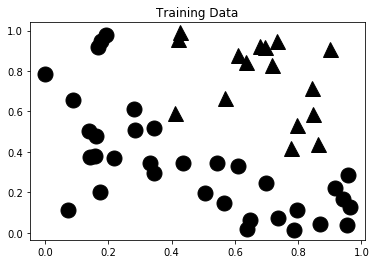

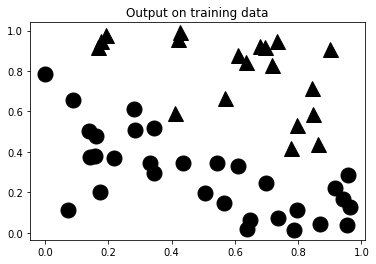

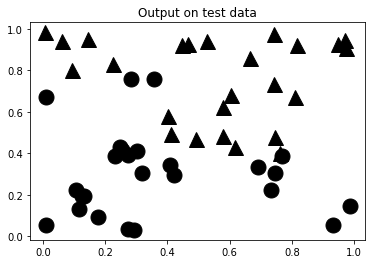

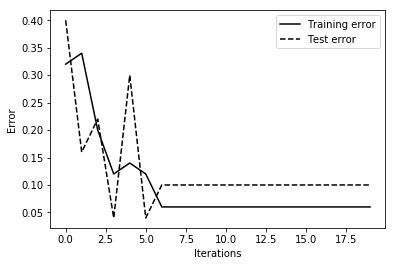

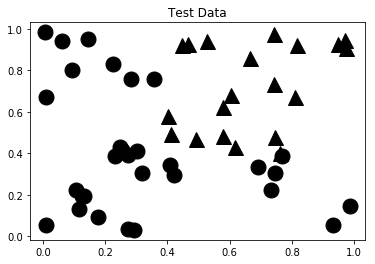

In [10]:
test_boost()

## Bagging

Bagging consists of the following steps:

* create $T$ bootstrap samples $S_{i}$,

* for each sample $S_{i}$ train a classifier,

* vote $f(x)=\text{arg}\max\sum_{i}^{T}(f_{i}(X)=y)$.


In [1]:
class dtree:
    """ A basic Decision Tree"""

    def __init__(self):
        """ Constructor """

    def read_data(self, filename):
        fid = open(filename, "r")
        data = []
        d = []
        for line in fid.readlines():
            d.append(line.strip())
        for d1 in d:
            data.append(d1.split(","))
        fid.close()

        self.featureNames = data[0]
        self.featureNames = self.featureNames[:-1]
        data = data[1:]
        self.classes = []
        for d in range(len(data)):
            self.classes.append(data[d][-1])
            data[d] = data[d][:-1]

        return data, self.classes, self.featureNames

    def classify(self, tree, datapoint):

        if type(tree) == type("string"):
            # Have reached a leaf
            return tree
        else:
            a = list(tree.keys())[0]
            for i in range(len(self.featureNames)):
                if self.featureNames[i] == a:
                    break

            try:
                t = tree[a][datapoint[i]]
                return self.classify(t, datapoint)
            except:
                return None

    def classifyAll(self, tree, data):
        results = []
        for i in range(len(data)):
            results.append(self.classify(tree, data[i]))
        return results

    def make_tree(self, data, classes, featureNames, maxlevel=-1, level=0, forest=0):
        """ The main function, which recursively constructs the tree"""

        nData = len(data)
        nFeatures = len(data[0])

        try:
            self.featureNames
        except:
            self.featureNames = featureNames

        # List the possible classes
        newClasses = []
        for aclass in classes:
            if newClasses.count(aclass) == 0:
                newClasses.append(aclass)

        # Compute the default class (and total entropy)
        frequency = np.zeros(len(newClasses))

        totalEntropy = 0
        totalGini = 0
        index = 0
        for aclass in newClasses:
            frequency[index] = classes.count(aclass)
            totalEntropy += self.calc_entropy(float(frequency[index]) / nData)
            totalGini += (float(frequency[index]) / nData) ** 2

            index += 1

        totalGini = 1 - totalGini
        default = classes[np.argmax(frequency)]

        if nData == 0 or nFeatures == 0 or (maxlevel >= 0 and level > maxlevel):
            # Have reached an empty branch
            return default
        elif classes.count(classes[0]) == nData:
            # Only 1 class remains
            return classes[0]
        else:

            # Choose which feature is best
            gain = np.zeros(nFeatures)
            ggain = np.zeros(nFeatures)
            featureSet = np.arange(nFeatures)
            if forest != 0:
                np.random.shuffle(featureSet)
                featureSet = featureSet[0:forest]
            for feature in featureSet:
                g, gg = self.calc_info_gain(data, classes, feature)
                gain[feature] = totalEntropy - g
                ggain[feature] = totalGini - gg

            bestFeature = np.argmax(gain)
            tree = {featureNames[bestFeature]: {}}

            # List the values that bestFeature can take
            values = []
            for datapoint in data:
                if datapoint[feature] not in values:
                    values.append(datapoint[bestFeature])

            for value in values:
                # Find the datapoints with each feature value
                newData = []
                newClasses = []
                index = 0
                for datapoint in data:
                    if datapoint[bestFeature] == value:
                        if bestFeature == 0:
                            newdatapoint = datapoint[1:]
                            newNames = featureNames[1:]
                        elif bestFeature == nFeatures:
                            newdatapoint = datapoint[:-1]
                            newNames = featureNames[:-1]
                        else:
                            newdatapoint = datapoint[:bestFeature]
                            newdatapoint.extend(datapoint[bestFeature + 1:])
                            newNames = featureNames[:bestFeature]
                            newNames.extend(featureNames[bestFeature + 1:])
                        newData.append(newdatapoint)
                        newClasses.append(classes[index])
                    index += 1

                # Now recurse to the next level
                subtree = self.make_tree(newData, newClasses, newNames, maxlevel, level + 1, forest)

                # And on returning, add the subtree on to the tree
                tree[featureNames[bestFeature]][value] = subtree

            return tree

    def printTree(self, tree, name):
        if type(tree) == dict:
            print(name, list(tree.keys())[0])
            for item in list(list(tree.values())[0].keys()):
                print(name, item)
                self.printTree(list(tree.values())[0][item], name + "\t")
        else:
            print
            name, "\t->\t", tree

    def calc_entropy(self, p):
        if p != 0:
            return -p * np.log2(p)
        else:
            return 0

    def calc_info_gain(self, data, classes, feature):

        # Calculates the information gain based on both entropy and the Gini impurity
        gain = 0
        ggain = 0
        nData = len(data)

        # List the values that feature can take

        values = []
        for datapoint in data:
            if datapoint[feature] not in values:
                values.append(datapoint[feature])

        featureCounts = np.zeros(len(values))
        entropy = np.zeros(len(values))
        gini = np.zeros(len(values))
        valueIndex = 0
        # Find where those values appear in data[feature] and the corresponding class
        for value in values:
            dataIndex = 0
            newClasses = []
            for datapoint in data:
                if datapoint[feature] == value:
                    featureCounts[valueIndex] += 1
                    newClasses.append(classes[dataIndex])
                dataIndex += 1

            # Get the values in newClasses
            classValues = []
            for aclass in newClasses:
                if classValues.count(aclass) == 0:
                    classValues.append(aclass)

            classCounts = np.zeros(len(classValues))
            classIndex = 0
            for classValue in classValues:
                for aclass in newClasses:
                    if aclass == classValue:
                        classCounts[classIndex] += 1
                classIndex += 1

            for classIndex in range(len(classValues)):
                entropy[valueIndex] += self.calc_entropy(float(classCounts[classIndex]) / np.sum(classCounts))
                gini[valueIndex] += (float(classCounts[classIndex]) / np.sum(classCounts)) ** 2

            # Computes both the Gini gain and the entropy
            gain = gain + float(featureCounts[valueIndex]) / nData * entropy[valueIndex]
            ggain = ggain + float(featureCounts[valueIndex]) / nData * gini[valueIndex]
            valueIndex += 1
        return gain, 1 - ggain

In [51]:
class bagger:
    """The bagging algorithm based on the decision tree of Chapter 6"""

    def __init__(self):
        """ Constructor """
        self.tree = dtree()

    def bag(self, data, targets, features, nSamples):

        nPoints = np.shape(data)[0]
        nDim = np.shape(data)[1]
        self.nSamples = nSamples

        # Compute bootstrap samples
        samplePoints = np.random.randint(0, nPoints, (nPoints, nSamples))
        classifiers = []

        for i in range(nSamples):
            sample = []
            sampleTarget = []
            for j in range(nPoints):
                sample.append(data[samplePoints[j, i]])
                sampleTarget.append(targets[samplePoints[j, i]])
            # Train classifiers
            classifiers.append(self.tree.make_tree(sample, sampleTarget, features, 1))

        return classifiers

    def bagclass(self, classifiers, data):

        decision = []
        # Majority voting
        for j in range(len(data)):
            outputs = []
            # print data[j]
            for i in range(self.nSamples):
                out = self.tree.classify(classifiers[i], data[j])
                if out is not None:
                    outputs.append(out)
            # List the possible outputs
            out = []
            for each in outputs:
                if out.count(each) == 0:
                    out.append(each)
            frequency = np.zeros(len(out))

            index = 0
            if len(out) > 0:
                for each in out:
                    frequency[index] = outputs.count(each)
                    index += 1
                decision.append(out[frequency.argmax()])
            else:
                decision.append(None)
        return decision

In [52]:
import numpy as np

tree = dtree()
bag  = bagger()

data,classes,features = tree.read_data('car.data')

train = data[::2][:]
test = data[1::2][:]
trainc = classes[::2]
testc = classes[1::2]

t=tree.make_tree(train,trainc,features)
out = tree.classifyAll(t,test)
tree.printTree(t,' ')
 
a = np.zeros(len(out))
b = np.zeros(len(out))
d = np.zeros(len(out))
 
for i in range(len(out)):
    if testc[i] == 'good' or testc[i]== 'v-good':
        b[i] = 1
        if out[i] == testc[i]:
            d[i] = 1
    if out[i] == testc[i]:
        a[i] = 1
print("Tree")
print("Number correctly predicted",str(np.sum(a)))
print("Number of testpoints ",str(len(a)))
print("Percentage Accuracy ",str(np.sum(a)/len(a)*100.0))
print("")
print("Number of cars rated as good or very good", str(np.sum(b)))
print("Number correctly identified as good or very good",str(np.sum(d)))
print("Percentage Accuracy",str(np.sum(d)/np.sum(b)*100.0))
 
c=bag.bag(train,trainc,features,100)
out = bag.bagclass(c,test)
 
a = np.zeros(len(out))
b = np.zeros(len(out))
d = np.zeros(len(out))
 
for i in range(len(out)):
    if testc[i] == 'good' or testc[i]== 'v-good':
        b[i] = 1
        if out[i] == testc[i]:
            d[i] = 1
    if out[i] == testc[i]:
        a[i] = 1
print("-----")
print("Bagger")
print("Number correctly predicted",str(np.sum(a)))
print("Number of testpoints ",str(len(a)))
print("Percentage Accuracy ",str(np.sum(a)/len(a)*100.0))

KeyboardInterrupt: 

### Homework. Random Forest. 

Build a random forest based on dtree class. Use the same dataset cars for testing.

### Random Forest: Solution

In [ ]:
Direct solution to the problem of building random_forest based on dtree() class is provided in Marsland Machine Learing repository
https://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html. My implementation will be based on it and provided with necessary comments. One has to observe, that random forest algorithm requires random selection of feature susbsets for each tree. Therefore, internal argument 'forest' has to be activated in tree.make_tree() method.  

In [58]:
class randomforest:

    def __init__(self):
        self.tree = dtree()
    
    # Arguments: data: predictors, targets: labels,  
    def bagging_samples(self,data,targets,features,nTrees,nSamples=1):
        #Getting number of points in dataset
        nPoints = np.shape(data)[0]
        #Getting number of predictors
        nDim = np.shape(data)[1]
        self.nSamples = nSamples
        self.nTrees = nTrees
        self.nFeatures = nFeatures
        self.features=features
        # Computing bootstrap samples. This approach is identical to bagger.bag() method, but I split the procedure
        # to bagging and tree building separately
        
        classifiers=[]
        sampleData_list=[]
        sampleTarget_list=[]
        
        for i in range(nTrees):
            #print i
            
            samplePoints = np.random.randint(0,nPoints,(nPoints,nSamples))
        
            for j in range(nSamples):
                sample = []
                sampleTarget = []
                for k in range(nPoints):
                    sample.append(data[samplePoints[k,j]])
                    sampleTarget.append(targets[samplePoints[k,j]])
            # Train classifiers
            sampleData_list.append(sample)
            sampleTarget_list.append(sampleTarget)
            #print (sampleData_list)
        self.bag=(sampleData_list,sampleTarget_list)
    # but trees with activated 'forest' option are generated
    
    def run_forest(self,nFeatures,maxlevel=2):
        classifiers=[]
        ind=0
        print(len(self.bag[0]))
        for i in range(len(self.bag[0])):
            ind+=1
            print (ind)
            #print (self.bag[0][i],self.bag[1][i])
            classifiers.append(self.tree.make_tree(self.bag[0][i],self.bag[1][i],self.features,maxlevel,forest=nFeatures))
        self.classifiers=classifiers
        return classifiers
    
    def classify_data(self,classifiers,data):
        decision = []
        # Majority voting
        for j in range(len(data)):
            outputs = []
            #print data[j]
            for i in range(self.nTrees):
                out = self.tree.classify(classifiers[i],data[j])
                if out is not None:
                    outputs.append(out)
            # List the possible outputs
            out = []
            for each in outputs:
                if out.count(each)==0:
                    out.append(each)
            frequency = np.zeros(len(out))
        
            index = 0
            if len(out)>0:
                for each in out:
                    frequency[index] = outputs.count(each)
                    index += 1
                decision.append(out[frequency.argmax()])
            else:
                decision.append(None)
        return decision

In [60]:
import numpy as np
import math

tree = dtree()
nTrees=5

data,classes,features = tree.read_data('car.data')

#Dividing by parity to test and train datasets
train = data[::2][:]
test = data[1::2][:]
trainc = classes[::2]
testc = classes[1::2]

print (features)

#nSamples=1
nFeatures=math.ceil(np.sqrt(len(features)))
#nFeatures=len(features)-1
#nFeatures=2

print (nFeatures)

forest=randomforest()
forest.bagging_samples(train,trainc,features,nTrees)
classifiers=forest.run_forest(nFeatures)
#out=forest.classify_data(classifiers,train)

['buying', 'maintenance', 'doors', 'persons', 'luggage', 'safety']
3
5
1
2
3
4
5


In [61]:
out=forest.classify_data(classifiers,train)
print (out)

['unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc', 'u

In [67]:
a = np.zeros(len(out))
b = np.zeros(len(out))
d = np.zeros(len(out))

for i in range(len(out)):
    if trainc[i] == 'good' or trainc[i]== 'v-good':
        b[i] = 1
        if out[i] == trainc[i]:
            d[i] = 1
    if out[i] == trainc[i]:
        a[i] = 1
print("Random forest for training set")
print("Number correctly predicted",str(np.sum(a)))
print("Number of testpoints ",str(len(a)))
print("Percentage Accuracy ",str(np.sum(a)/len(a)*100.0))
print("")
print("Number of cars rated as good or very good", str(np.sum(b)))
print("Number correctly identified as good or very good",str(np.sum(d)))
print("Percentage Accuracy",str(np.sum(d)/np.sum(b)*100.0))
print("---------------")

a = np.zeros(len(out))
b = np.zeros(len(out))
d = np.zeros(len(out))

for i in range(len(out)):
    if testc[i] == 'good' or testc[i]== 'v-good':
        b[i] = 1
        if out[i] == testc[i]:
            d[i] = 1
    if out[i] == testc[i]:
        a[i] = 1
print("\n\n\nRandom forest for test set")
print("Number correctly predicted",str(np.sum(a)))
print("Number of testpoints ",str(len(a)))
print("Percentage Accuracy ",str(np.sum(a)/len(a)*100.0))
print("")
print("Number of cars rated as good or very good", str(np.sum(b)))
print("Number correctly identified as good or very good",str(np.sum(d)))
print("Percentage Accuracy",str(np.sum(d)/np.sum(b)*100.0))


Random forest for training set
Number correctly predicted 726.0
Number of testpoints  864
Percentage Accuracy  84.02777777777779

Number of cars rated as good or very good 30.0
Number correctly identified as good or very good 0.0
Percentage Accuracy 0.0
---------------



Random forest for test set
Number correctly predicted 501.0
Number of testpoints  864
Percentage Accuracy  57.986111111111114

Number of cars rated as good or very good 39.0
Number correctly identified as good or very good 0.0
Percentage Accuracy 0.0


# Final comment

The result presented above is very unsatisfying. However, the reason for that lies not in random forest implementation, but in dtree() class itself,
which runs very slowly; it is practically impossible to use trees with depth>2. The calculation proceeds in reasonable time only for maxlevel=1, but 
then there is no chance to observe very_good or good labels, which are not frequent. The quality of fit could be improved by choosing greater nTree variable. However, that means few more hours of computation. 